In [1]:
from preprocess import *
from utils import *
import random
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import Model

import seaborn as sns


np.random.seed(2)
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, MaxPooling2D, UpSampling2D, Input, Concatenate, Conv2DTranspose, BatchNormalization,Reshape
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageChops, ImageEnhance,ImageFilter, ImageOps
from io import BytesIO
import cv2
from scipy.fftpack import dct
from scipy import ndimage
from scipy import fftpack
import optuna

In [2]:
def map_image(img_path,mascara):
    img = cv2.imread(img_path)

    # Dilatar las zonas detectadas para unirlas en áreas continuas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))

    dilated = cv2.dilate(mascara, kernel, iterations=15)
    
    # Calcular la distancia Euclidiana de cada píxel al contorno más cercano
    dist_transform = cv2.distanceTransform(dilated, cv2.DIST_L2, 3)
    dist_transform_norm = cv2.normalize(dist_transform, None, 0, 1, cv2.NORM_MINMAX)

    # Asignar un mapa de color a la imagen normalizada de distancia
    heatmap = cv2.applyColorMap(np.uint8(dist_transform_norm*255), cv2.COLORMAP_JET)

    #redimensionar la imagen para que coincida con la imagen original
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Superponer el mapa de calor a la imagen original
    result = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return result

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 4s 4s/step
Name of the image: 01 (1).jpeg
Class prediction: fake with probability: 0.5390207767486572
1/1 [==============================] - 0s 112ms/step


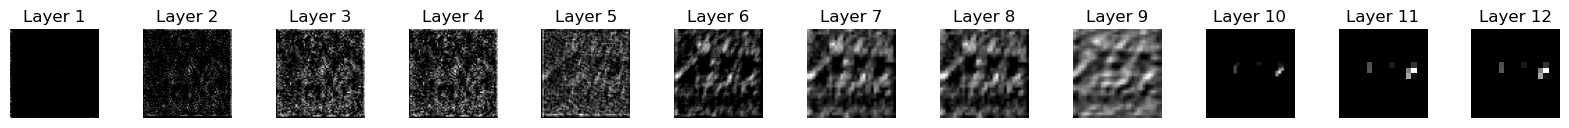

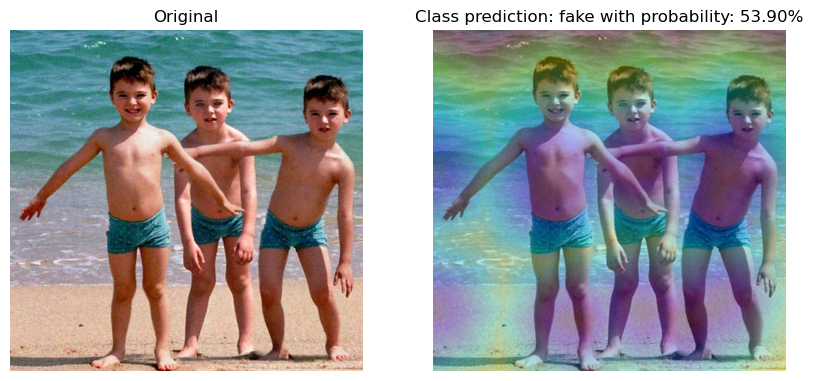

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 19ms/step
Name of the image: 01 (1).jpg
Class prediction: fake with probability: 0.9590209722518921
1/1 [==============================] - 0s 86ms/step


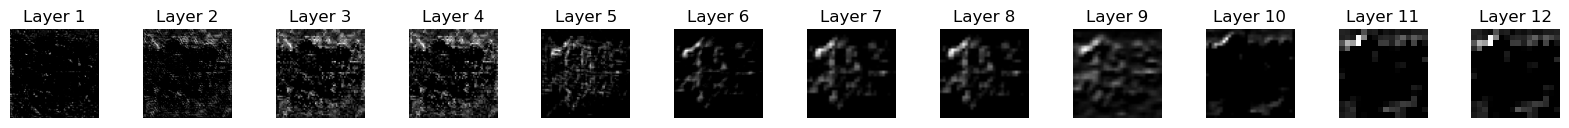

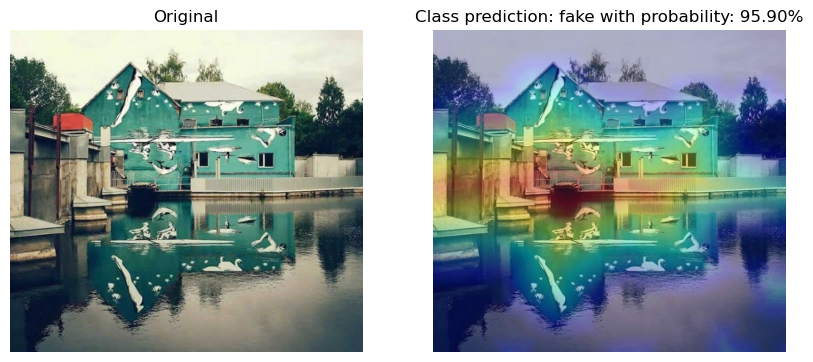

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 23ms/step
Name of the image: 01 (10).jpg
Class prediction: real with probability: 0.9783161282539368
1/1 [==============================] - 0s 84ms/step


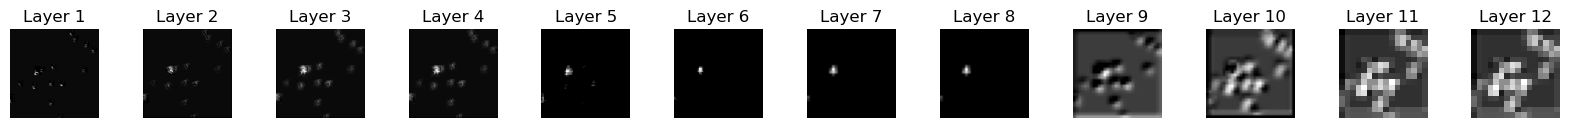

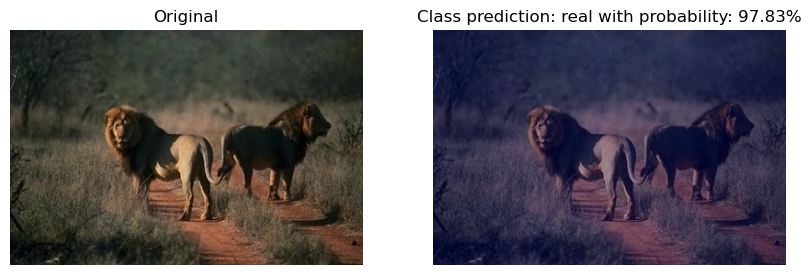

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 19ms/step
Name of the image: 01 (11).jpg
Class prediction: real with probability: 0.9870992302894592
1/1 [==============================] - 0s 84ms/step


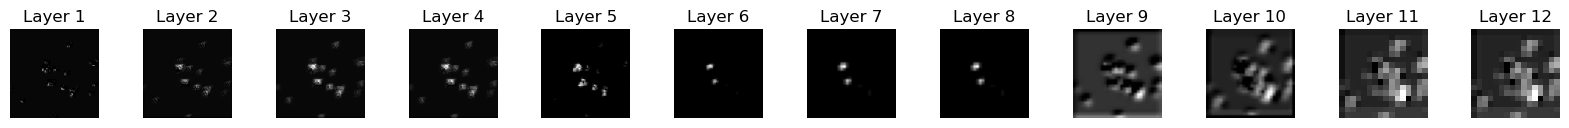

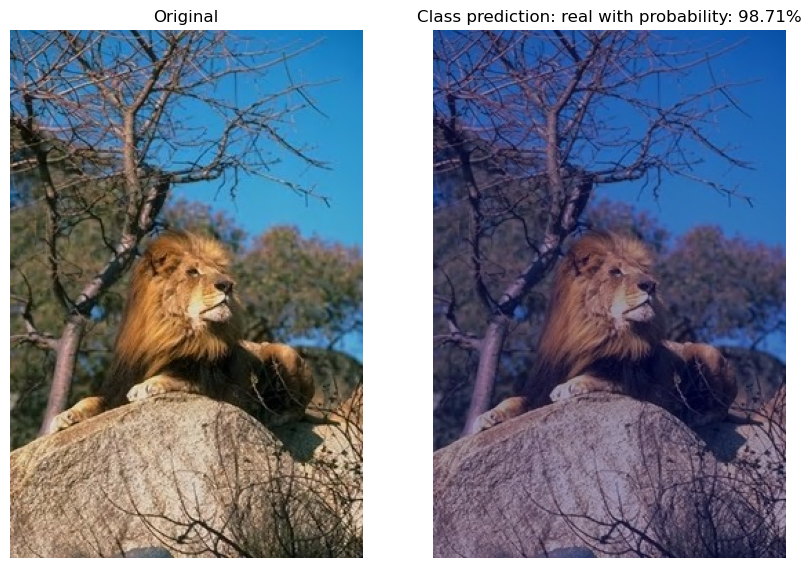

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 20ms/step
Name of the image: 01 (12).jpg
Class prediction: real with probability: 0.9439574480056763
1/1 [==============================] - 0s 87ms/step


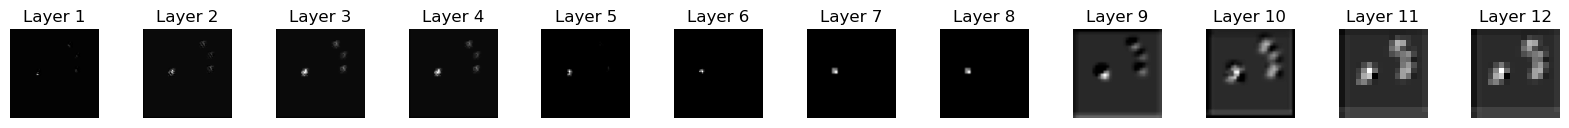

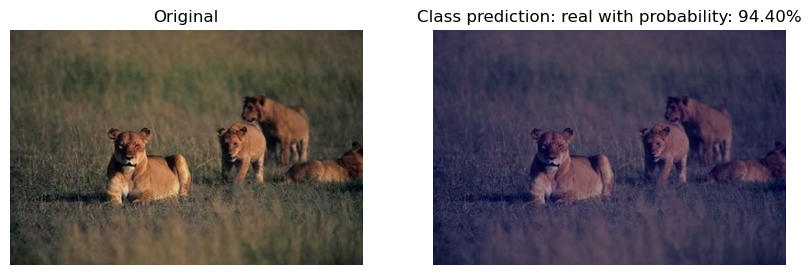

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 26ms/step
Name of the image: 01 (13).jpg
Class prediction: fake with probability: 0.8304570913314819
1/1 [==============================] - 0s 110ms/step


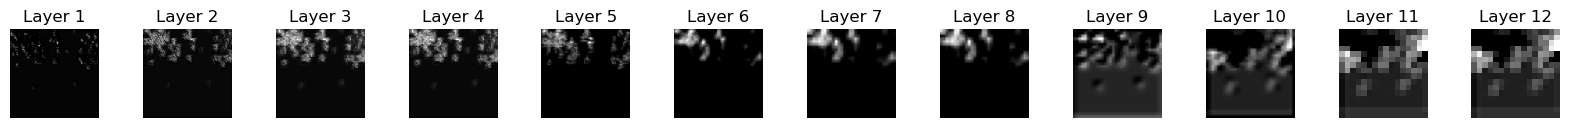

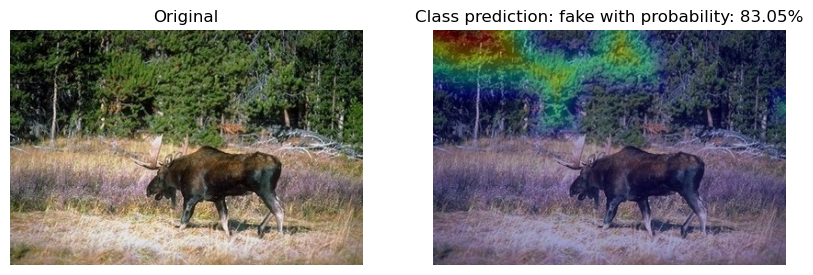

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 23ms/step
Name of the image: 01 (14).jpg
Class prediction: fake with probability: 0.8450482487678528
1/1 [==============================] - 0s 87ms/step


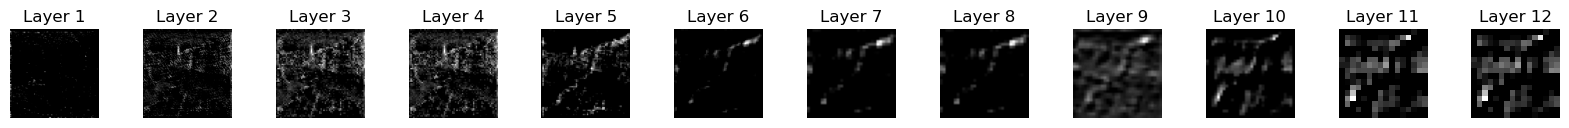

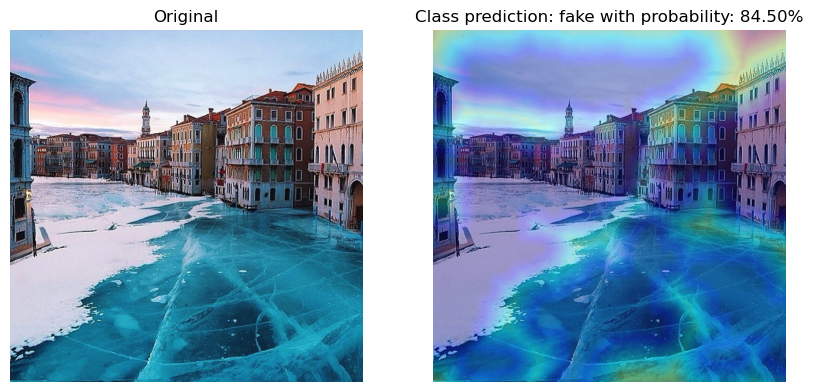

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 30ms/step
Name of the image: 01 (15).jpg
Class prediction: real with probability: 0.916109561920166
1/1 [==============================] - 0s 84ms/step


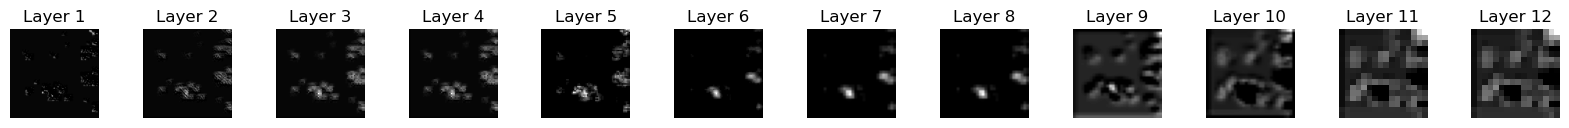

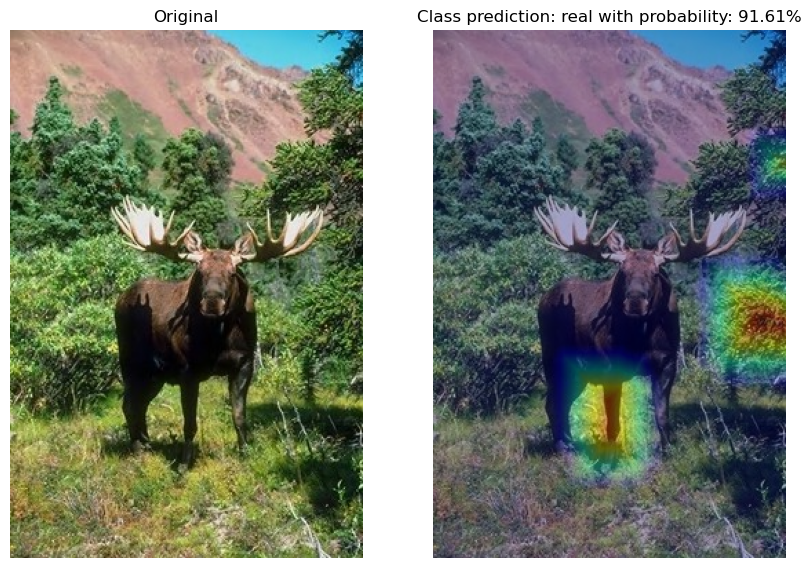

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 19ms/step
Name of the image: 01 (16).jpg
Class prediction: fake with probability: 0.8758856058120728
1/1 [==============================] - 0s 89ms/step


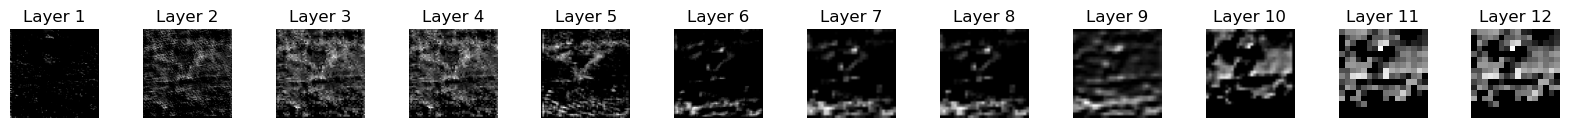

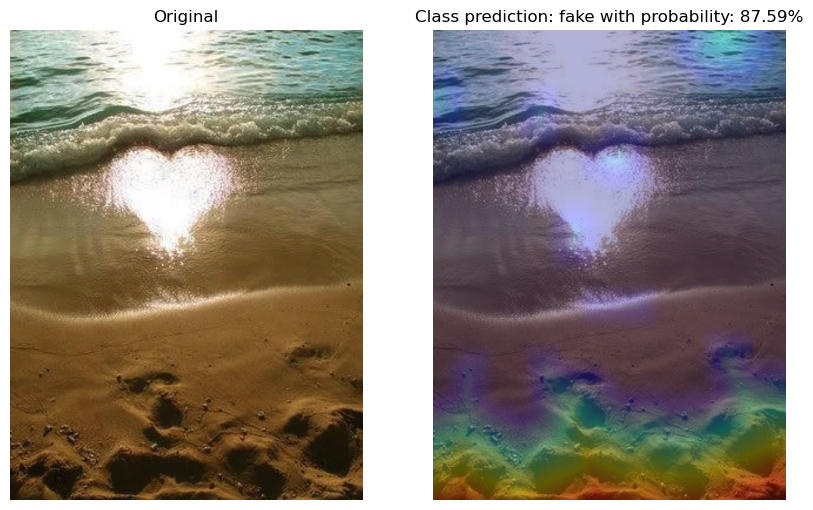

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 21ms/step
Name of the image: 01 (17).jpg
Class prediction: fake with probability: 0.9402643442153931
1/1 [==============================] - 0s 89ms/step


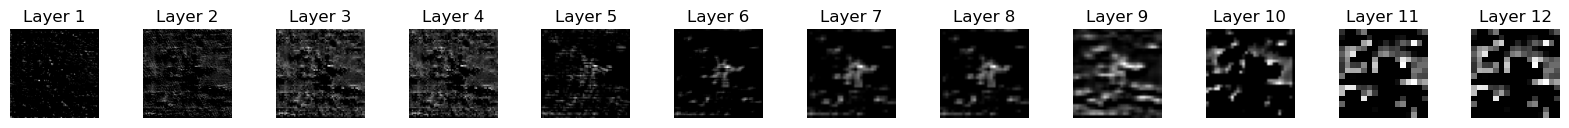

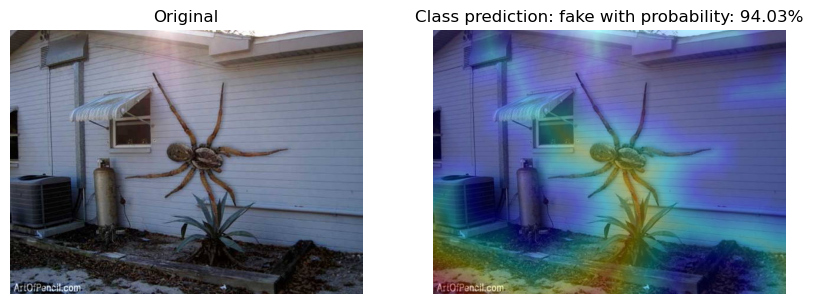

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 22ms/step
Name of the image: 01 (18).jpg
Class prediction: real with probability: 0.9992203712463379
1/1 [==============================] - 0s 107ms/step


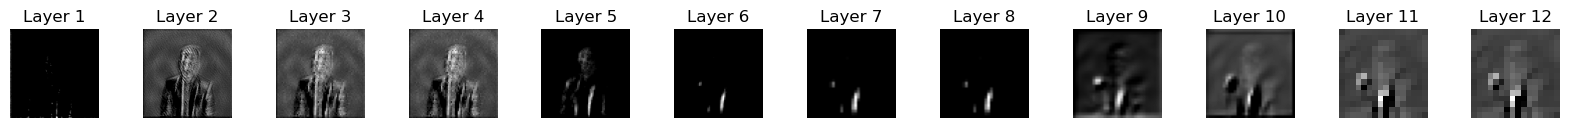

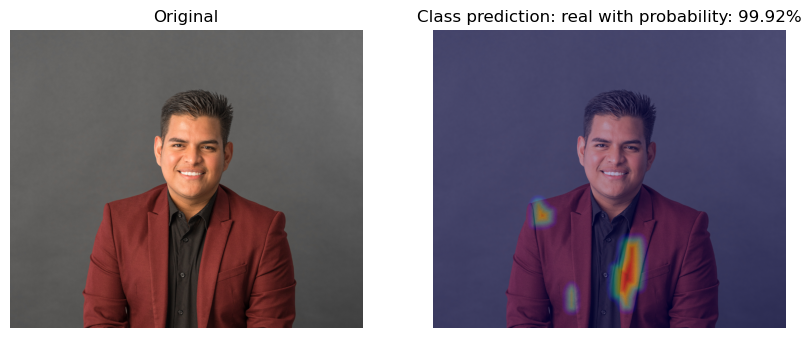

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 18ms/step
Name of the image: 01 (19).jpg
Class prediction: fake with probability: 0.951070249080658
1/1 [==============================] - 0s 105ms/step


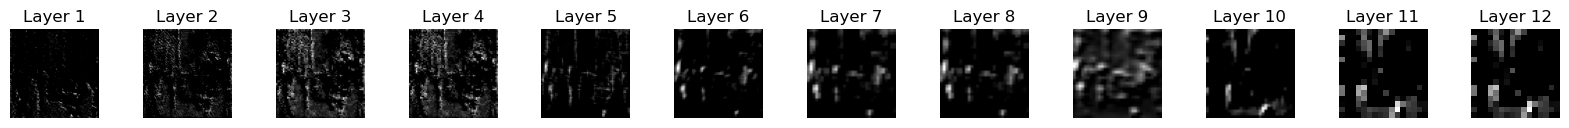

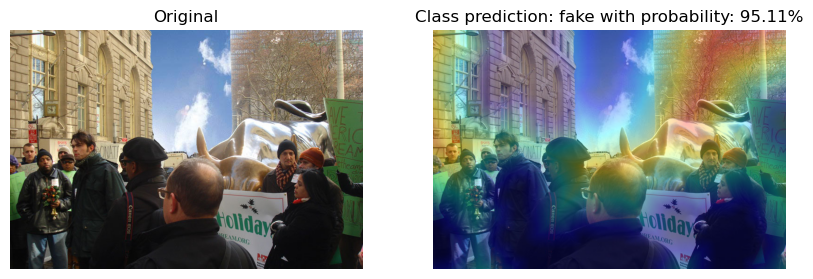

Prediccion de modelo para la imagen de prueba
1/1 [==============================] - 0s 18ms/step
Name of the image: 01 (2).jpeg
Class prediction: real with probability: 0.9969456791877747
1/1 [==============================] - 0s 96ms/step


KeyboardInterrupt: 

In [7]:
# Path to the images test
images_path = '../tests/*.*'

class_names = ['real', 'fake']
image_size = (128, 128)

# Cargar el modelo entrenado
model = load_model('../model.h5')

correct = 0
total  = 0

for image_path in glob.glob(images_path)[0:1000]:

    # mostrar la imagen original
    img = cv2.imread(image_path)

    img_copy = img.copy()

    # Preparar la imagen para el modelo
    img = preparete_image(image_path, image_size)
    img = np.array(img).reshape(-1, image_size[0], image_size[1], 3)

    # Hacer la predicción
    print("Prediccion de modelo para la imagen de prueba")
    y_pred = model.predict(img)

    # Imprimir la predicción
    print("Name of the image: {}".format(os.path.basename(image_path)))
    print('Class prediction: {}'.format(class_names[np.argmax(y_pred)]) + ' with probability: {}'.format(np.max(y_pred)))

    #obtener la ultima capa de model.layers
    layer_outputs = [layer.output for layer in model.layers[0:12]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img)

    plt.figure(figsize=(20, 6))
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:
            activation = activation[0]
        
            plt.subplot(1, len(activations), i+1)
            plt.title('Layer {}'.format(i+1))

            for j in range(activation.shape[-1]):
                plt.imshow(activation[:, :, j], cmap='gray')
                plt.axis('off')
                plt.subplots_adjust(wspace=0.5)
    plt.show()


    #generar una mascara a partir de 5ta capa de activacion
    mask = activations[8][0, :, :, 0]

    #aplicar mascara a la img_copy
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    img_copy = img_copy.astype('float32') / 255

    mask = cv2.resize(mask, (img_copy.shape[1], img_copy.shape[0]))

    mask = cv2.merge([mask, mask, mask])

    # pasar la mascara a  imagen de 3 canales
    mask = (mask * 255).astype(np.uint8)

    # Convertir a escala de grises
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización
    _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

    # Encontrar contornos en la máscara binaria
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    resultado = map_image(image_path, gray_mask)

    # Mostrar las 3 imágenes
    plt.figure(figsize=(10, 40))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_copy)
    plt.title('Original')
    plt.axis('off')  # Quita los ejes numéricos
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB))
    plt.title('Class prediction: {}'.format(class_names[np.argmax(y_pred)]) + ' with probability: {:.2%}'.format(np.max(y_pred)))
    plt.axis('off')  # Quita los ejes numéricos
    
    plt.show()